# Root Locus Design

## ZN Tuning

In [1]:
import requests as req, os

URL = "https://raw.githubusercontent.com/mit-acl/16_06_Class/main/"
File = ["basic_material.py","control_materials.py"]

if not os.path.isfile(File[0]):
    print('Basic files not found - downloading them')
    for dfile in File:
        if not os.path.isfile(dfile):
            print("Downloading "+dfile)
            res = req.get(URL+dfile)
            file = open(dfile, 'w')
            file.write(res.text)
            file.close()

print('Basic file found')
%run basic_material.py

from control.matlab import tf, rlocus, step, feedback, pade

from control_materials import *

Basic file found
Running Python: 3.12.8
Running Sympy: 1.13.2
Control Package Found
This is a library of useful functions for the control systems in 16.06


## Find Parameters of System response on 10-14

In [2]:
G = tf((0, 1), np.convolve((1,3),np.convolve((1,1),(1,2))))
if 1:
    T_delay = 0.5
    num,den = pade(T_delay, 2)
    G *= tf(num, den)

[y,t] = step(G)
A = y.max()

dy = np.diff(y)
ddy = np.diff(dy)
II = np.max(np.where(ddy >= 0)) # find point of inflection (max slope)
R = (y[II] - y[II-1])/(t[II] - t[II-1]) # find actual slope
L = t[II] - y[II]/R # project slope to xaxis and find offset = L
t2 = (A-y[II])/R + t[II] # time to get to max resp at rate R
tau = t2 - L

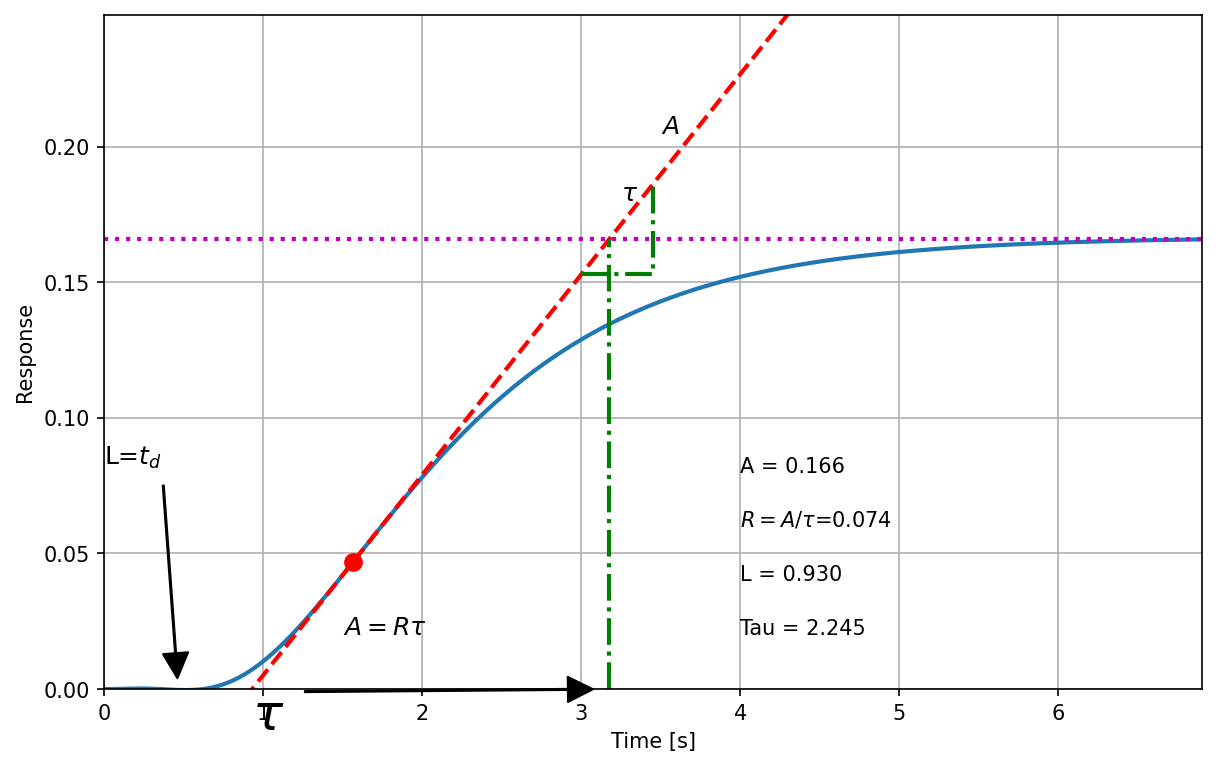

In [3]:
fig, ax = plt.subplots(1, figsize=(8, 5),dpi=150,constrained_layout = True)
plt.plot(t,y)
plt.plot(t[II],y[II],'ro',ms=8); # point of inflection
plt.plot([t[0], t[-1]],[np.max(y), np.max(y)],'m:');
plt.plot(t,R*(t-t[II])+y[II],'r--');
plt.plot([t2, t2],[0., np.max(y)],'g-.');

x = 3
mag = 5
plt.plot([x, x+tau/mag, x+tau/mag],[(x-L)*R, (x-L)*R, (x-L)*R+A/mag],'g-.');
plt.text(3.25,.18,r'$\tau$',fontsize=12)
plt.text(3.5,.205,r'$A$',fontsize=12)

plt.text(4,.08,"A = {:4.3f}".format(A))
plt.text(4,.06,r'$R = A/\tau$={:4.3f}'.format(R))
plt.text(4,.04,"L = {:4.3f}".format(L))
plt.text(4,.02,"Tau = {:4.3f}".format(tau))

ax.set_xlabel('Time [s]')
ax.set_ylabel('Response')
plt.xlim([0, max(t)]);
plt.ylim([0, 1.5*A]);

plt.annotate(r'L=$t_d$', xy=(L/2, 0), xytext=(0, A/2), arrowprops=dict(facecolor='black', shrink=.05, width=0.5),fontsize=12)
plt.annotate(r'$\tau$', xy=(L+tau, 0), xytext=(L, -0.015), arrowprops=dict(facecolor='black', shrink=.05, width=0.5),fontsize=24)
plt.text(1.5,.02,r'$A=R\tau$',fontsize=12)
savefig("./figs/L12_ZN2.pdf", dpi=600)

plt.show()

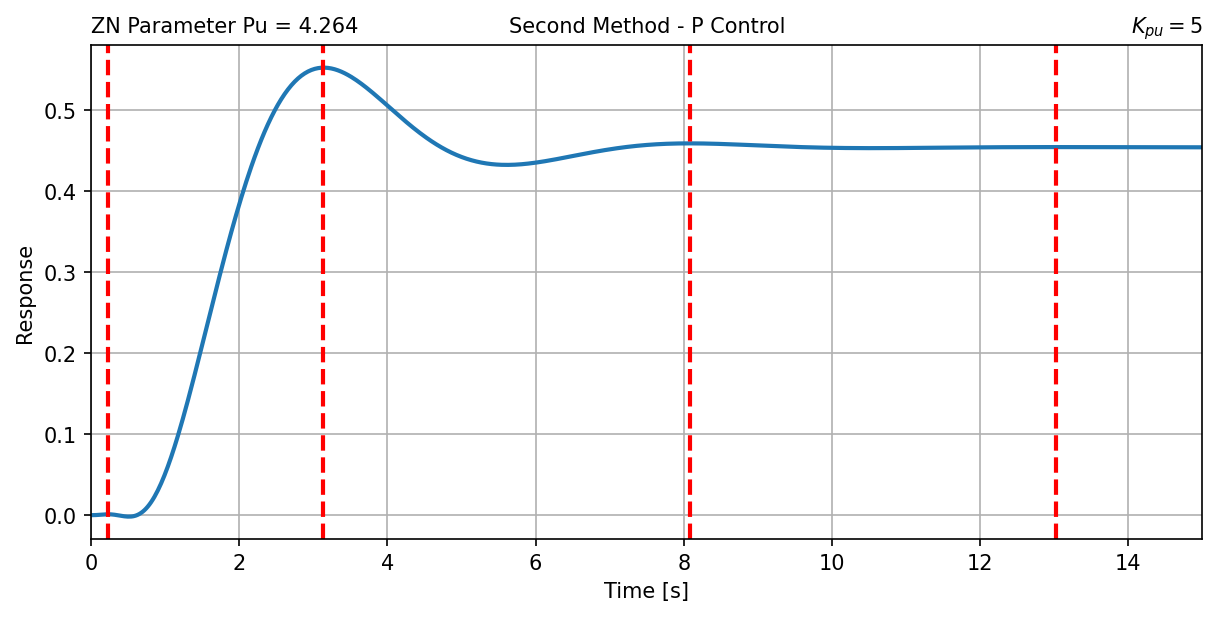

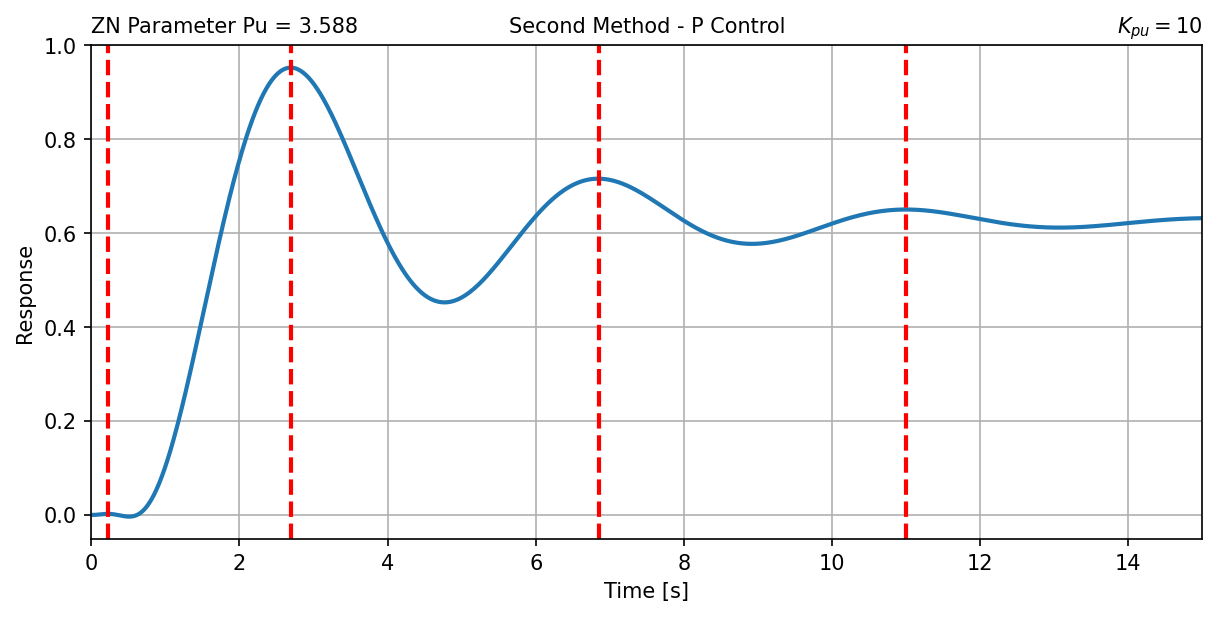

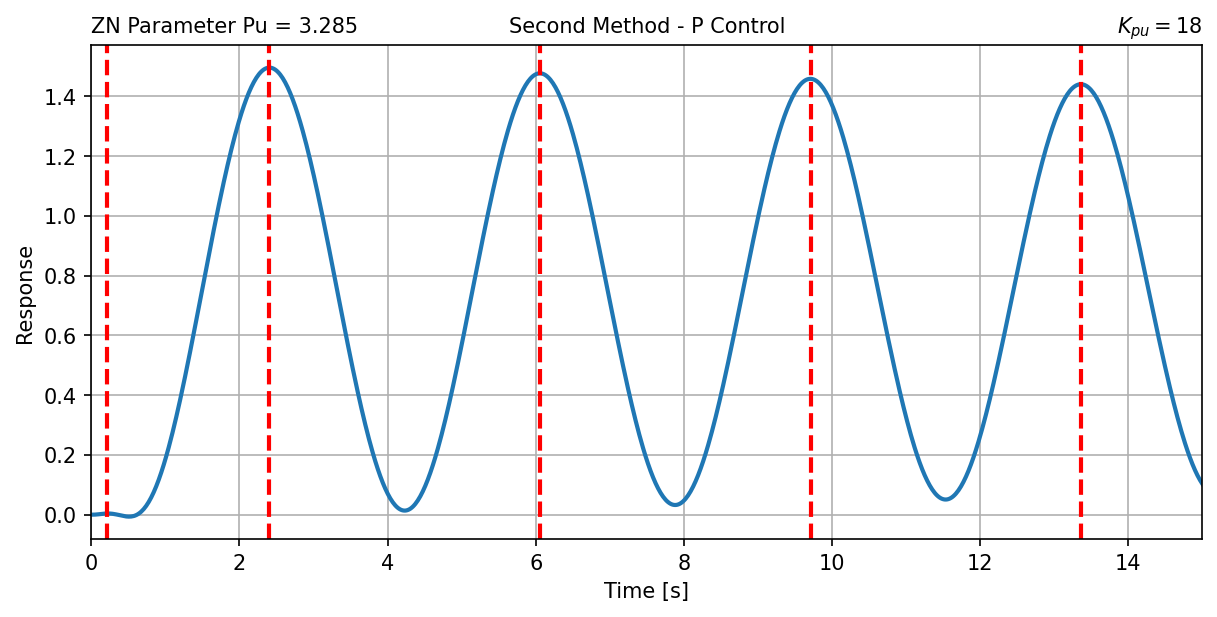

In [4]:
from scipy.signal import find_peaks

def ZNplot(Kpu = 60, ax=ax):
    Gclp = feedback(Kpu*G,1)
    
    [yy,tt] = step(Gclp,15);
    ax.plot(tt,yy)
    
    LOCS,_ = find_peaks(yy)
    [ax.axvline(x=tt[LOCS[kk]],color='red',ls='dashed') for kk in range(len(LOCS))]
    
    Pu = np.mean(np.diff(tt[LOCS]));
    ax.set_title("ZN Parameter Pu = {:4.3f}".format(Pu),loc='left')
    
    ax.set_title('Second Method - P Control')
    ax.set_title(r'$K_{{pu}}={:3.0f}$'.format(Kpu),loc='right')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Response')
    return Pu

Kpu = 5 # guess
fig, ax = plt.subplots(1, figsize=(8, 4),dpi=150,constrained_layout = True)
Pu = ZNplot(Kpu,ax=ax)
savefig("./figs/L12_ZN1a.pdf", dpi=600)

Kpu = 10 # guess
fig, ax = plt.subplots(1, figsize=(8, 4),dpi=150,constrained_layout = True)
Pu = ZNplot(Kpu,ax=ax)
savefig("./figs/L12_ZN1b.pdf", dpi=600)

Kpu = 18 # guess
fig, ax = plt.subplots(1, figsize=(8, 4),dpi=150,constrained_layout = True)
Pu = ZNplot(Kpu,ax=ax)
savefig("./figs/L12_ZN1.pdf", dpi=600)


In [5]:
# Process Reaction Method

def pid(Kp = 0, Ki = 0, Kd = 0):
    s = tf((1,0),(1))
    return tf(Kp,1) + Ki/s + Kd*s
    
# P
Kp = tau/L
Gcp = pid(Kp = Kp)

# PI
Kp = 0.9*tau/L
Ki = 0.27*tau/L
Gcpi = pid(Kp = Kp, Ki = Ki)

# PID
Kp = 1.2*tau/L
Ki = 0.6*tau/L**2
Kd = 0.6*tau
Gcpid = pid(Kp = Kp, Ki = Ki, Kd = Kd)

In [6]:
Gclp=feedback(Gcp*G,1)
Gclpi=feedback(Gcpi*G,1)
Gclpid=feedback(Gcpid*G,1)
Gcpid

TransferFunction(array([   1.347,    2.897,    1.558]), array([1, 0]))

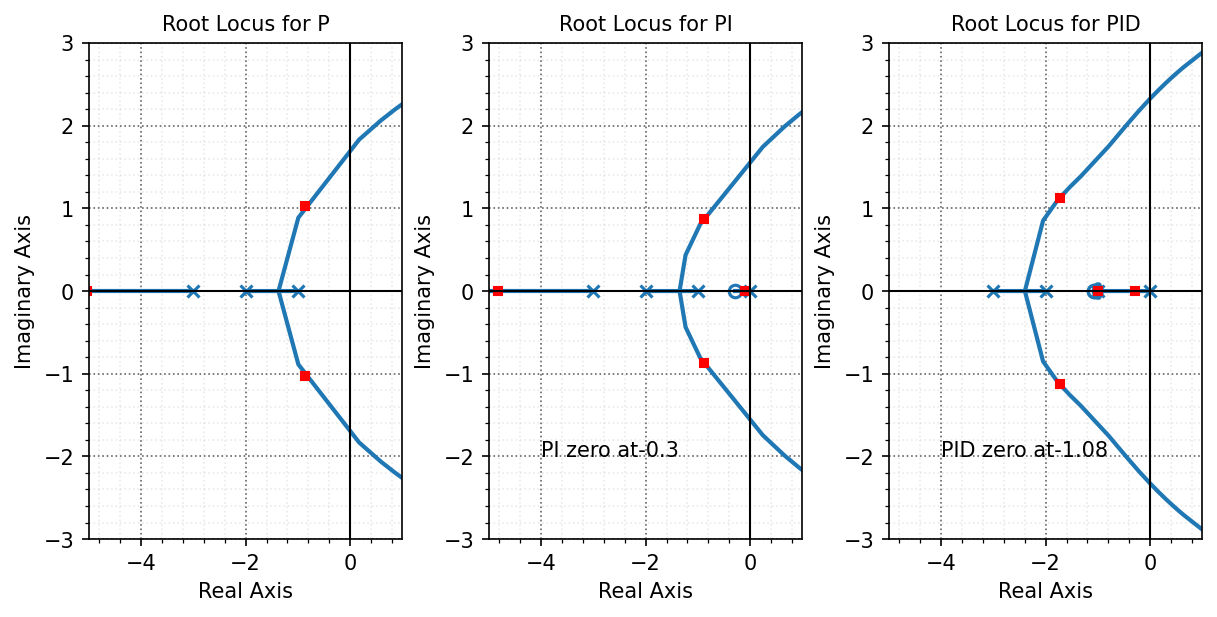

In [7]:
fig, ax = plt.subplots(1,3, figsize=(8, 4),dpi=150,constrained_layout = True)
rlocus(Gcp*G,ax=ax[0],grid=False)
scl = Gclp.poles()
ax[0].plot(scl.real,scl.imag,'rs',ms=4)
ax[0].set_xlim([-5, 1])
ax[0].set_ylim([-3, 3])
ax[0].set_title('Root Locus for P')

rlocus(Gcpi*G,ax=ax[1],grid=False)
scl = Gclpi.poles()
ax[1].plot(scl.real,scl.imag,'rs',ms=4)
ax[1].set_xlim([-5, 1])
ax[1].set_ylim([-3, 3])
ax[1].text(-4,-2,"PI zero at"+str(round(float(np.real(Gcpi.zeros()[0])),2)))
ax[1].set_title('Root Locus for PI')

rlocus(Gcpid*G,ax=ax[2],grid=False)
scl = Gclpid.poles()
ax[2].plot(scl.real,scl.imag,'rs',ms=4)
ax[2].set_xlim([-5, 1])
ax[2].set_ylim([-3, 3])
ax[2].set_title('Root Locus for PID')
ax[2].text(-4,-2,"PID zero at"+str(round(float(np.real(Gcpid.zeros()[0])),2)))

for ii in range(len(ax)):
    ax[ii].set_xlabel('Real Axis')
    ax[ii].set_ylabel('Imaginary Axis')
    nicegrid(ax[ii])
savefig("./figs/L12_ZN3.pdf", dpi=600)
plt.show()

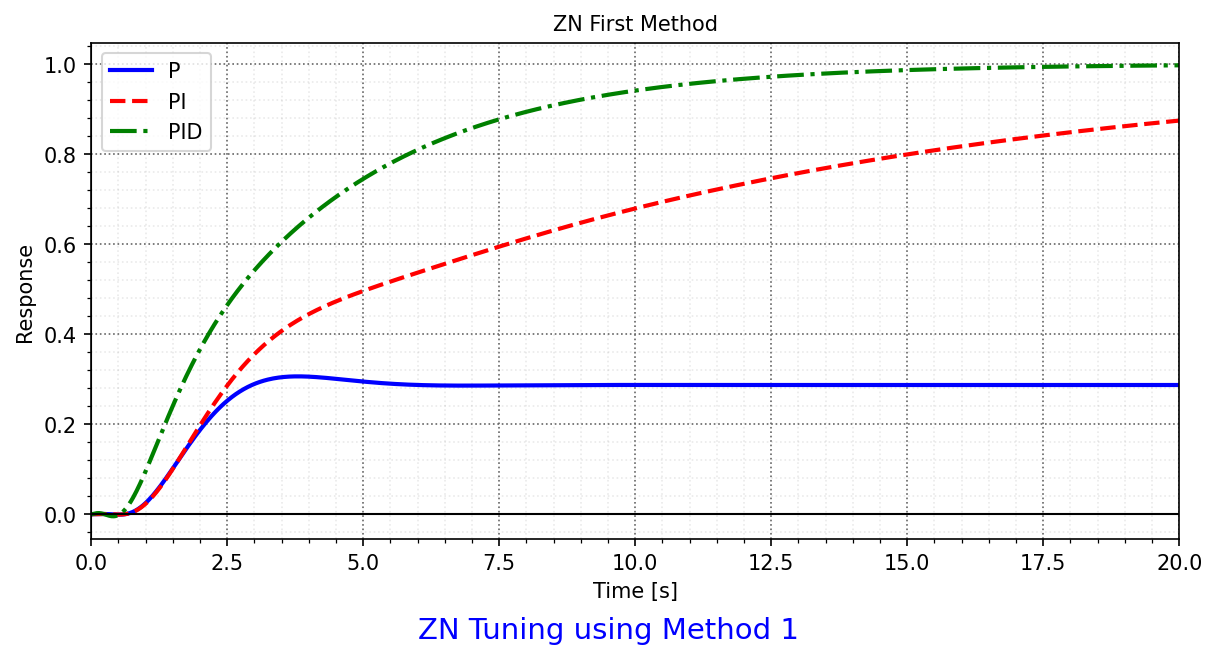

In [8]:
fig, ax = plt.subplots(figsize=(8, 4),dpi=150,constrained_layout = True)
yp,tp = step(Gclp,20)
ypi,tpi = step(Gclpi,20)
ypid,tpid = step(Gclpid,20)

plt.plot(tp,yp,'b-',label='P')
plt.plot(tpi,ypi,'r--',label='PI')
plt.plot(tpid,ypid,'g-.',label='PID')
nicegrid(ax)

plt.legend()
plt.title("ZN First Method")
plt.xlabel("Time [s]")
plt.ylabel("Response")
caption("ZN Tuning using Method 1",fig,yloc=-0.05)
savefig("./figs/L12_ZN4.pdf", dpi=600)
plt.show()

In [9]:
# Second Method
# P
Kp = 0.5*Kpu
Gcp = pid(Kp = Kp)
# PI
Kp = 0.45*Kpu
Ki = 0.54*Kpu/Pu
Gcpi = pid(Kp = Kp, Ki = Ki)
# PID
Kp = 0.6*Kpu
Ki = 1.2*Kpu/Pu
Kd = 0.075*Kpu*Pu
Gcpid = pid(Kp = Kp, Ki = Ki , Kd = Kd)

Gclp = feedback(Gcp*G,1)
Gclpi = feedback(Gcpi*G,1)
Gclpid = feedback(Gcpid*G,1)
pretty_row_print(Gcpid.zeros())
Gcpid

-1.217, -1.217


TransferFunction(array([   4.435,   10.800,    6.574]), array([1, 0]))

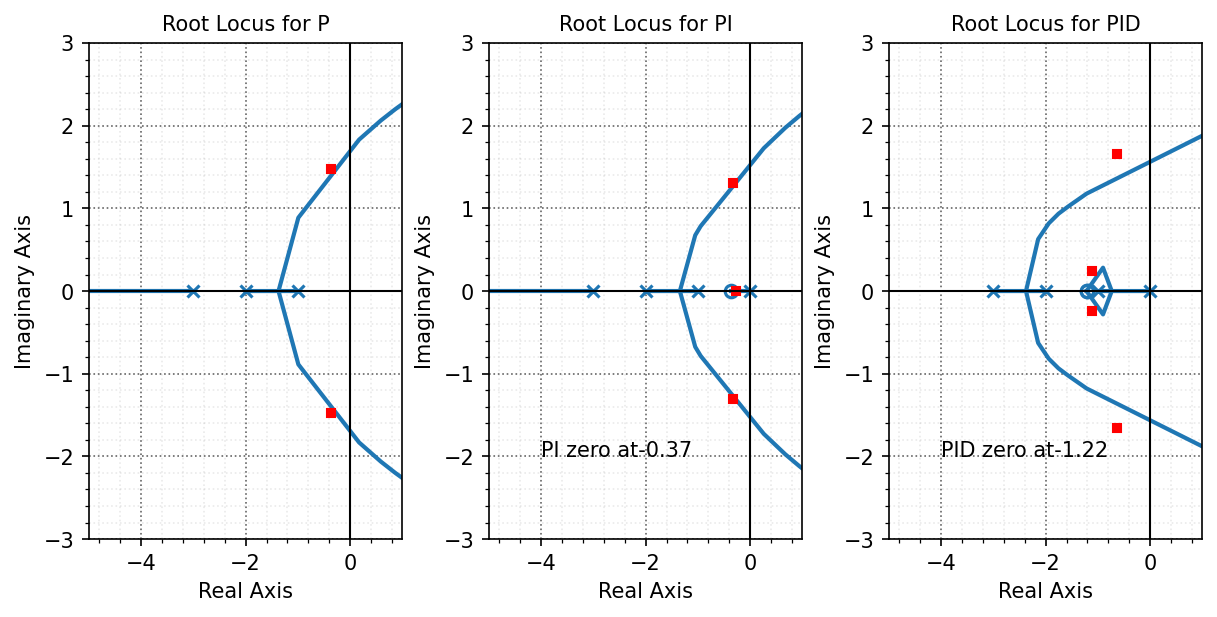

In [10]:
fig, ax = plt.subplots(1,3, figsize=(8, 4),dpi=150,constrained_layout = True)

rlocus(Gcp*G,ax=ax[0],grid=False)
scl = Gclp.poles()
ax[0].plot(scl.real,scl.imag,'rs',ms=4)
ax[0].set_xlim([-5, 1])
ax[0].set_ylim([-3, 3])
ax[0].set_title('Root Locus for P')

rlocus(Gcpi*G,ax=ax[1],grid=False)
scl = Gclpi.poles()
ax[1].plot(scl.real,scl.imag,'rs',ms=4)
ax[1].set_xlim([-5, 1])
ax[1].set_ylim([-3, 3])
ax[1].set_title('Root Locus for PI')
ax[1].text(-4,-2,"PI zero at"+str(round(float(np.real(Gcpi.zeros()[0])),2)))

rlocus(Gcpid*G,ax=ax[2],grid=False)
scl = Gclpid.poles()
ax[2].plot(scl.real,scl.imag,'rs',ms=4)
ax[2].set_xlim([-5, 1])
ax[2].set_ylim([-3, 3])
ax[2].set_title('Root Locus for PID')
ax[2].text(-4,-2,"PID zero at"+str(round(float(np.real(Gcpid.zeros()[0])),2)))

for ii in range(len(ax)):
    ax[ii].set_xlabel('Real Axis')
    ax[ii].set_ylabel('Imaginary Axis')
    nicegrid(ax[ii])
savefig("./figs/L12_ZN5.pdf", dpi=600)
plt.show()

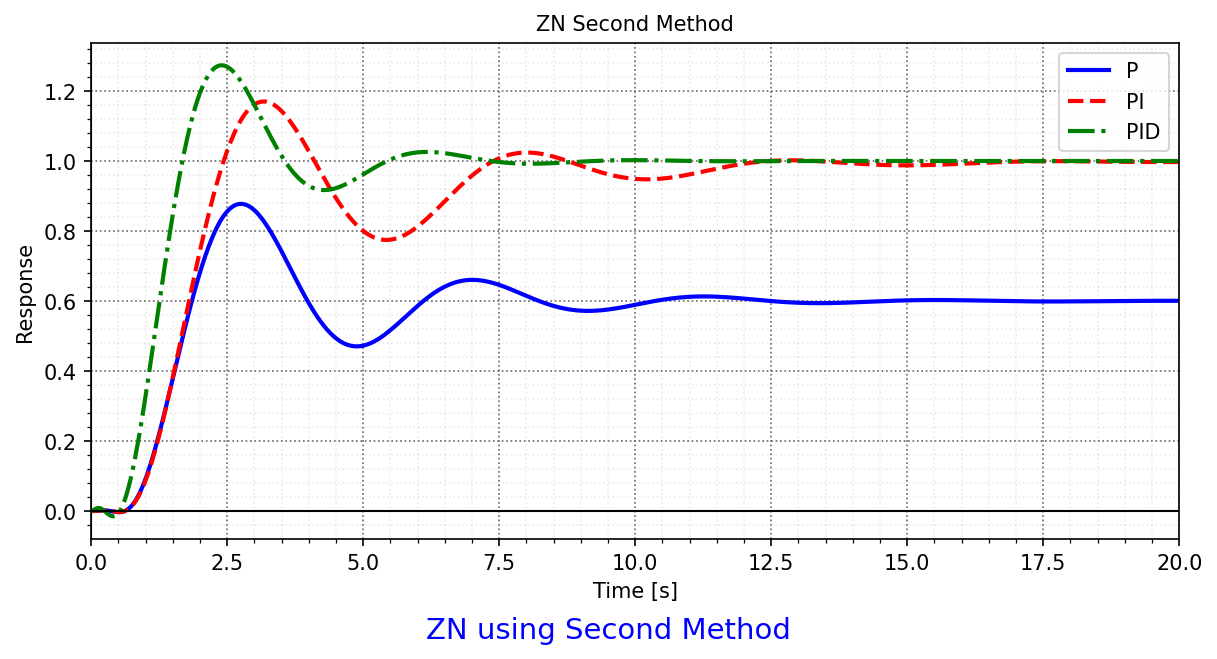

In [11]:
fig, ax = plt.subplots(figsize=(8, 4),dpi=150,constrained_layout = True)
yp,tp = step(Gclp,20)
ypi,tpi = step(Gclpi,20)
ypid,tpid = step(Gclpid,20)

plt.plot(tp,yp,'b-',label='P')
plt.plot(tpi,ypi,'r--',label='PI')
plt.plot(tpid,ypid,'g-.',label='PID')

nicegrid(ax)
plt.title("ZN Second Method")
plt.xlabel("Time [s]")
plt.ylabel("Response")
plt.legend()
caption("ZN using Second Method",fig,yloc=-0.05)
savefig("./figs/L12_ZN6.pdf", dpi=600)
plt.show()

## Manual Tuning Approach

Kp = 17.457


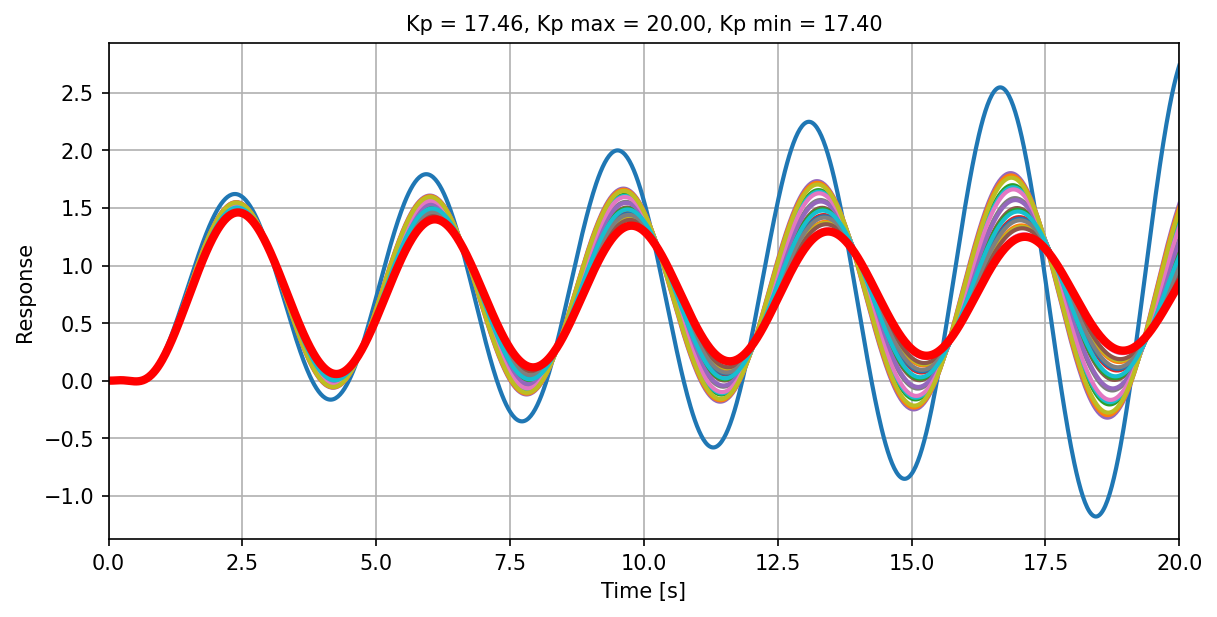

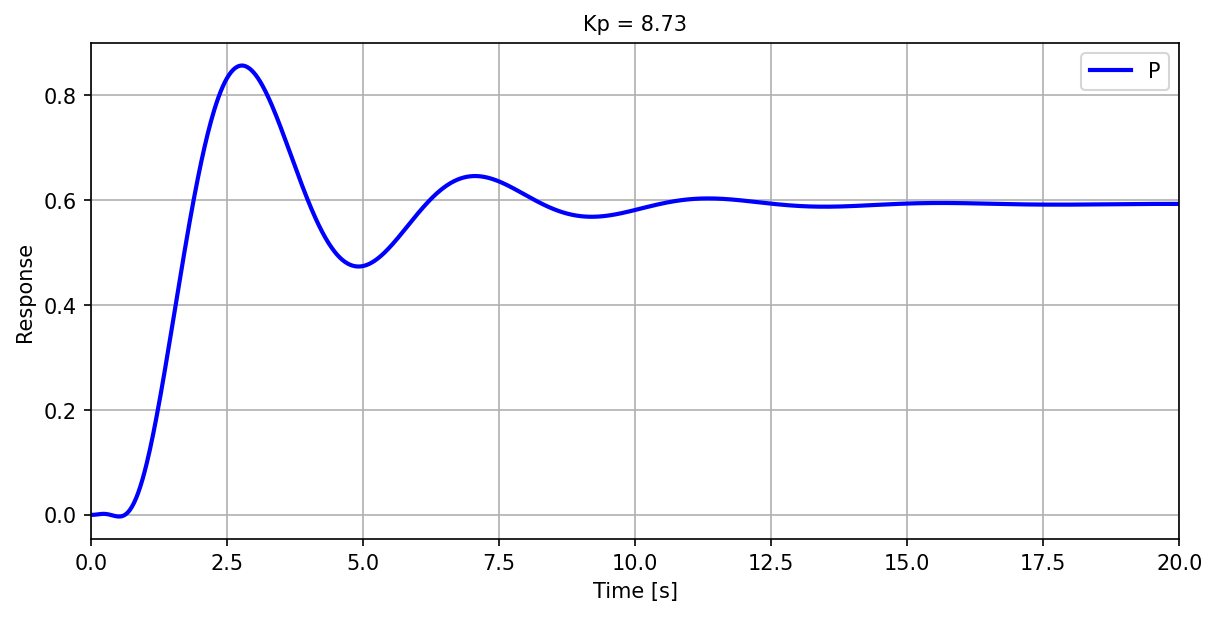

In [12]:
fig, ax = plt.subplots(figsize=(8, 4),dpi=150,constrained_layout = True)
G = tf((0, 1), np.convolve((1,3),np.convolve((1,1),(1,2))))
if 1:
    T_delay = 0.5
    num,den = pade(T_delay, 2)
    G *= tf(num, den)

tt = np.linspace(0,20,1000)
d_alpha = 1/np.sqrt(2)

def pick_Kp(G, Kp = 20):
    Kp_max = Kp
    Kp_min = Kp
    # look for when the peaks are increasing or decreasing
    # if increasing, decrease Kp
    # if decreasing, increase Kp
    for kk in range(200): # number of iterations
        Gc = pid(Kp = Kp)
        Gcl = feedback(Gc*G,1)
        [y,t] = step(Gcl,T=tt)
        if kk%10 == 0:
            plt.plot(t,y)
        peaks, _ = find_peaks(y)
        peak_values = y[peaks]
        Kp_max = max(Kp,Kp_max)
        Kp_min = min(Kp,Kp_min)

        if len(peak_values) < 2:
            continue
        peak_diffs = np.diff(peak_values)
        num_positive = np.sum(peak_diffs > 0)
        num_negative = np.sum(peak_diffs < 0)
        #print(f"Pos {num_positive} Neg {num_negative} Kp = {Kp:.3f}")
        if num_positive > num_negative:
            # Peaks are increasing in size
            Kp -= np.sqrt(d_alpha)
        elif num_positive < num_negative:
            # Peaks are decreasing in size
            Kp += d_alpha
        else:
            print(f"Iteration {kk}: Kp = {Kp:.3f}")
            break

    Gc = pid(Kp = Kp)
    Gcl = feedback(Gc*G,1)
    [y,t] = step(Gcl,T=tt)
    plt.plot(t,y,'r',linewidth=4)
    plt.xlabel('Time [s]')
    plt.ylabel('Response')
    plt.title(f"Kp = {Kp:.2f}, Kp max = {Kp_max:.2f}, Kp min = {Kp_min:.2f}")
    print(f"Kp = {Kp:4.3f}")
    savefig("./figs/L10_Manual_PID1.pdf", dpi=600)
    return Kp/2 # return Kp/2 as the ROT


Kp = pick_Kp(G)
fig, ax = plt.subplots(figsize=(8, 4),dpi=150,constrained_layout = True)
Gc = pid(Kp = Kp)
Gcl = feedback(Gc*G,1)
[y_p,t_p] = step(Gcl,max(tt))
plt.plot(t_p,y_p,'b',label='P')
plt.xlabel('Time [s]')
plt.ylabel('Response')
plt.legend()
plt.title(f"Kp = {Kp:.2f}")
savefig("./figs/L10_Manual_PID2.pdf", dpi=600)
plt.show()

kk = 0.00 Steady state value = 0.593
kk = 0.10 Steady state value = 0.888
kk = 0.20 Steady state value = 0.974
kk = 0.30 Steady state value = 0.994
kk = 0.40 Steady state value = 0.996
kk = 0.50 Steady state value = 0.994


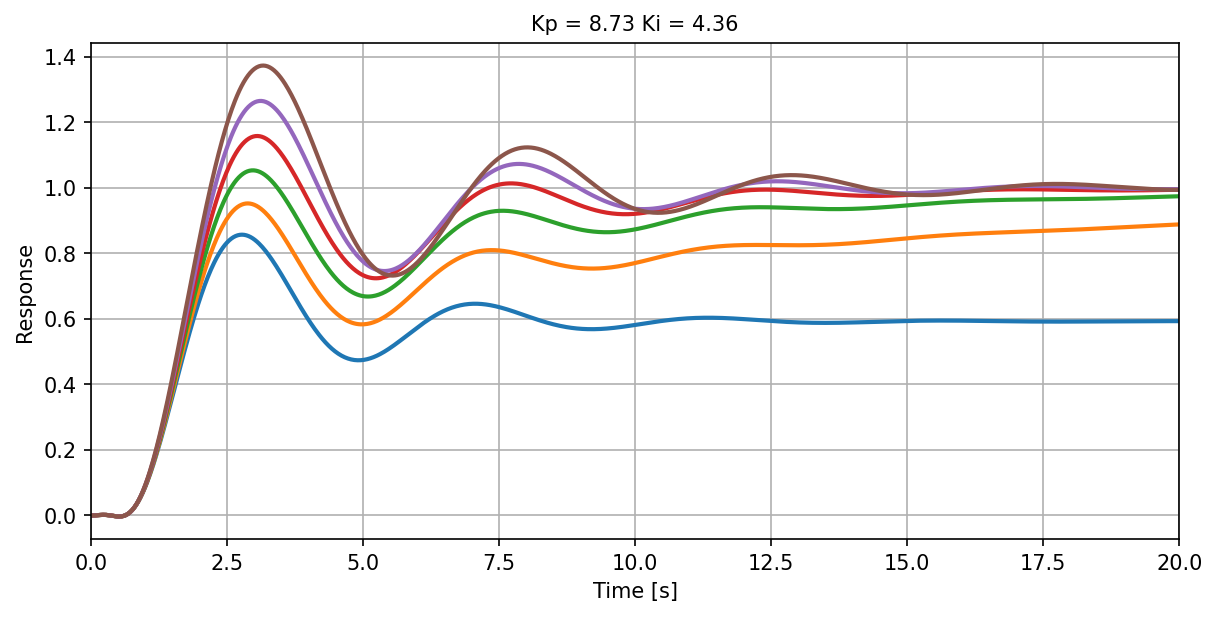

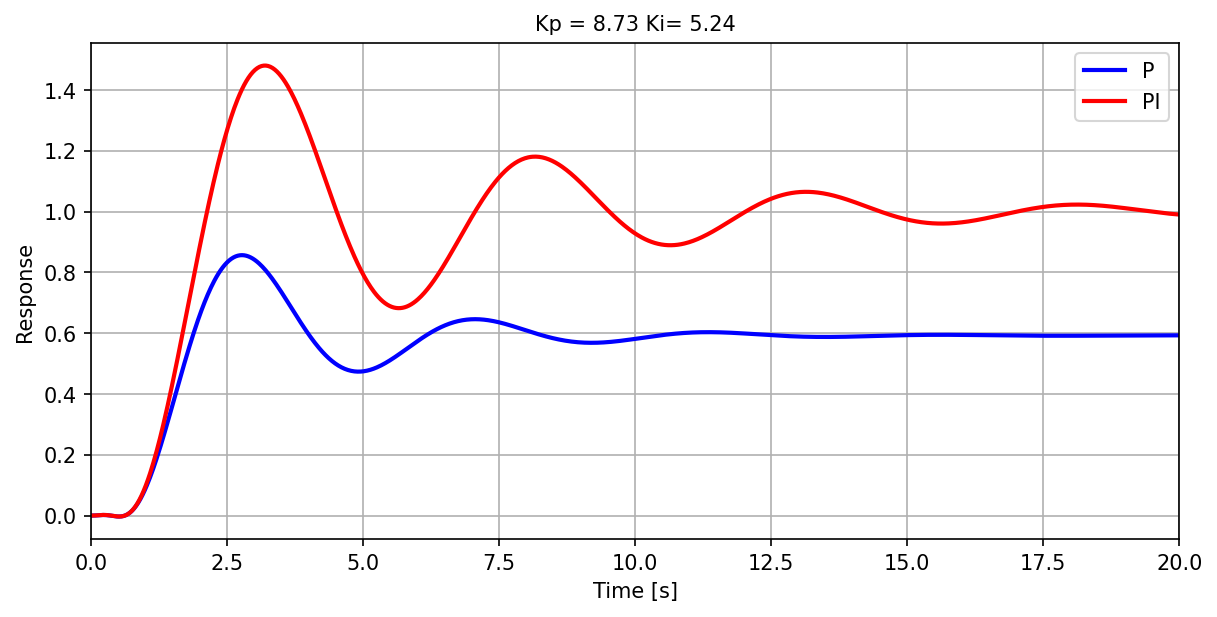

In [13]:
fig, ax = plt.subplots(figsize=(8, 4),dpi=150,constrained_layout = True)
for kk in np.arange(0, .6, 0.1):
    Ki = kk*Kp
    Gc = pid(Kp = Kp, Ki = Ki)
    Gcl = feedback(Gc*G,1)
    [y,t] = step(Gcl,max(tt))
    print("kk = {:3.2f} Steady state value = {:4.3f}".format(kk,y[-1]))
    plt.plot(t,y)
    plt.xlabel('Time [s]')
    plt.ylabel('Response')
    plt.title(f"Kp = {Kp:.2f} Ki = {Ki:.2f}")
savefig("./figs/L10_Manual_PID3.pdf", dpi=600)
plt.show()

Ki = 0.6*Kp
Gc = pid(Kp = Kp, Ki = Ki)
fig, ax = plt.subplots(figsize=(8, 4),dpi=150,constrained_layout = True)
Gcl = feedback(Gc*G,1)
[y_pi,t_pi] = step(Gcl,max(tt))
plt.plot(t_p,y_p,'b',label='P')
plt.plot(t_pi,y_pi,'r',label='PI')
plt.xlabel('Time [s]')
plt.ylabel('Response')
plt.legend()
plt.title(f"Kp = {Kp:.2f} Ki= {Ki:.2f}")
savefig("./figs/L10_Manual_PID4.pdf", dpi=600)
plt.show()

Converged to 5 using Kd = 3.700


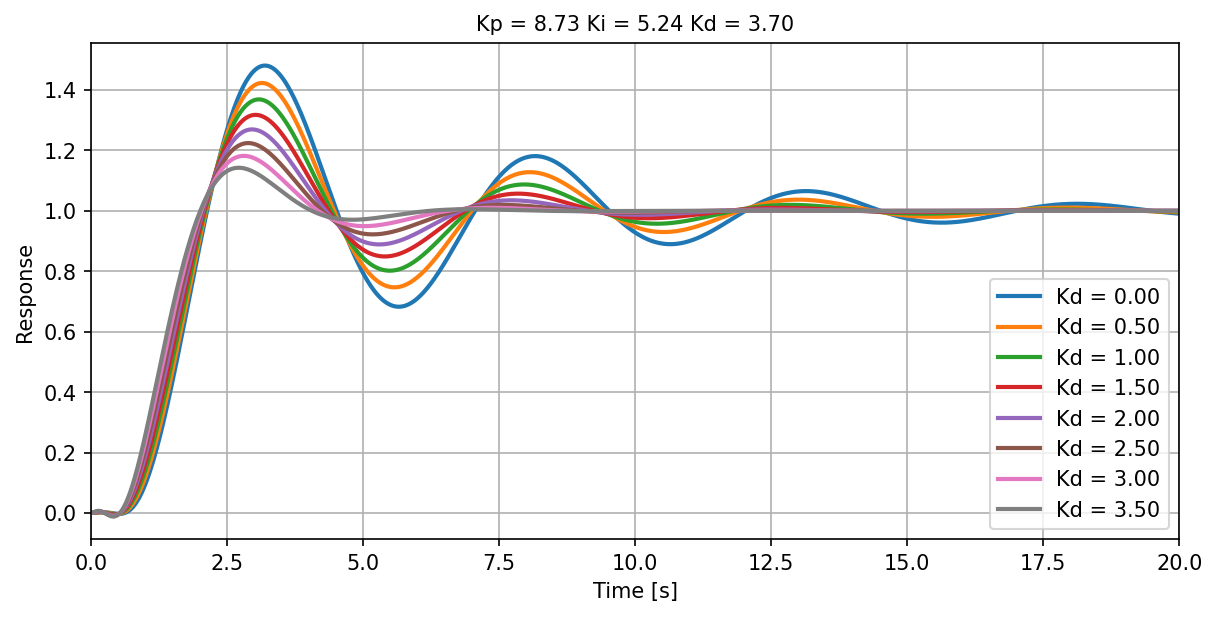

In [14]:
yss = 1
kd = 0
ts_target = 5

fig, ax = plt.subplots(figsize=(8, 4), dpi=150, constrained_layout=True)
for kk in range(100):
    Gc = pid(Kp=Kp, Ki=Ki, Kd=kd)
    Gcl = feedback(Gc * G, 1)
    [y, t] = step(Gcl, max(tt))
    if kk%5 == 0:
        plt.plot(t, y, label=f"Kd = {kd:.2f}")
    err = np.abs(y - yss)
    last_time = t[np.where(err > 0.02)[0][-1]]
    if last_time < (ts_target - 0.05):
        kd -= 1./3.
    elif last_time > (ts_target + 0.05):
        kd += 0.1
    else:
        print("Converged to {:d} using Kd = {:4.3f}".format(ts_target, kd))
        break
plt.xlabel('Time [s]')
plt.ylabel('Response')
plt.legend()
plt.title(f"Kp = {Kp:.2f} Ki = {Ki:.2f} Kd = {kd:.2f}")
Kd = kd
savefig("./figs/L10_Manual_PID5.pdf", dpi=600)
plt.show()


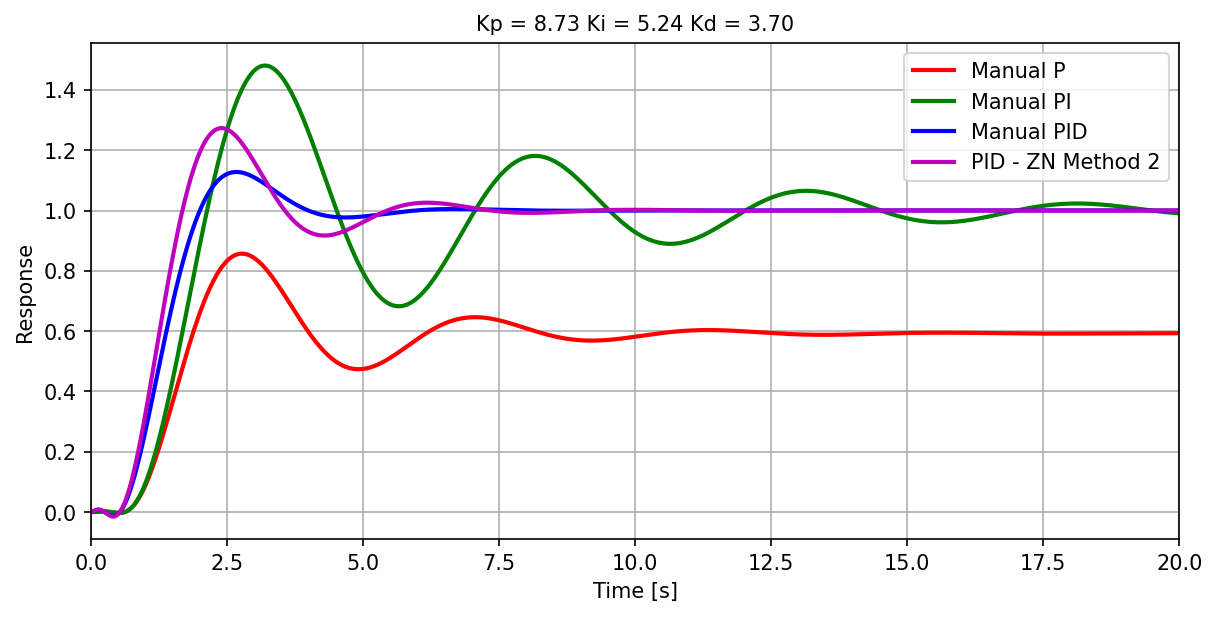

In [15]:
Gc = pid(Kp=Kp, Ki=Ki, Kd=Kd)
fig, ax = plt.subplots(figsize=(8, 4), dpi=150, constrained_layout=True)
Gcl = feedback(Gc * G, 1)
[y, t] = step(Gcl, max(tt))

plt.plot(t_p, y_p, 'r', label='Manual P')
plt.plot(t_pi, y_pi, 'g', label='Manual PI')
plt.plot(t, y, 'b', label='Manual PID')
plt.plot(tpid, ypid, 'm', label='PID - ZN Method 2')
plt.xlim(0,max(tt))
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Response')
plt.title(f"Kp = {Kp:.2f} Ki = {Ki:.2f} Kd = {Kd:.2f}")
savefig("./figs/L10_Manual_PID6.pdf", dpi=600)
plt.show()

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact

global t, y0, y_p, y_pi, y_pd, y_pid

from control.matlab import tf, feedback, step, pade
from control_materials import *

if 1:
    Tf = 100
    Tmax= 20
    T_delay = 0.5
    num,den = pade(T_delay, 2)
    G = tf((0, 1), np.convolve((1,3),np.convolve((1,1),(1,2))))*tf(num, den)
else:
    Tf = 10
    Tmax= 2
    G = tf(1,(1,.5))
    
def reset():
    global t, y0, y_p, y_pi, y_pd, y_pid
    y_pi = y0
    y_pd = y0
    y_pid = y0

t = np.linspace(0, Tf, 2000)
y0 = np.zeros_like(t)
reset()

def run_simulation(Kp, Ki, Kd):
    global t, y0, y_p, y_pi, y_pd, y_pid
    Gc = pid(Kp = Kp, Ki = Ki, Kd = Kd)
    Gcl = feedback(Gc * G, 1)
    y, t = step(Gcl, T=t)

    if Ki == 0 and Kd == 0:
        y_p = y
        reset()
    elif Ki != 0 and Kd == 0:
        y_pi = y
    elif Ki == 0 and Kd != 0:
        y_pd = y
    else: #Ki != 0 and Kd != 0
        y_pid = y
    
    fig, ax = plt.subplots(figsize=(8, 5), dpi=150, constrained_layout=True)
    plt.axhline(y[-1], xmin=0.5, color='k', linestyle='--')
    plt.plot(t, y_p, 'r-', label='P')
    plt.plot(t, y_pi, 'g-', label='PI')
    plt.plot(t, y_pd, 'c-', label='PD')
    plt.plot(t, y_pid, 'm-', label='PID')
    plt.ylim(-0.2,2)
    plt.xlim(0, Tmax)
    plt.xlabel('Time [s]')
    plt.ylabel('Response')
    plt.text(0.5, 1.75, fr'$K_p =$ {Kp:.2f}, $K_i =$ {Ki:.2f}, $K_d =$ {Kd:.2f}', fontsize=10)
    plt.legend()
    plt.title(fr'Simulation with $K_p =$ {Kp:.2f}, $K_i =$ {Ki:.2f}, $K_d =$ {Kd:.2f}')
    plt.show()

# Interactive sliders for Kp, Ki, and Kd
interact(run_simulation, 
         Kp=widgets.FloatSlider(min=0, max=30, step=0.1, value=1.0),
         Ki=widgets.FloatSlider(min=0, max=20, step=0.1, value=0.),
         Kd=widgets.FloatSlider(min=0, max=10, step=0.1, value=0.));

interactive(children=(FloatSlider(value=1.0, description='Kp', max=30.0), FloatSlider(value=0.0, description='…

In [17]:
Gss = control.matlab.tf2ss(G)
Gss.A

array([[ -18.000, -131.000, -426.000, -600.000, -288.000],
       [   1.000,    0.000,    0.000,    0.000,    0.000],
       [   0.000,    1.000,    0.000,    0.000,    0.000],
       [   0.000,    0.000,    1.000,    0.000,    0.000],
       [   0.000,    0.000,    0.000,    1.000,    0.000]])

In [18]:
Gss.B

array([[   1.000],
       [   0.000],
       [   0.000],
       [   0.000],
       [   0.000]])

In [19]:
Gss.C

array([[   0.000,    0.000,    1.000,  -12.000,   48.000]])